# UMAP Visualization: 32k Token Sample

Simple visualization to see the shape of semantic space at 32k scale.

**Steps:**
1. Load precomputed 32k distance matrix
2. Reconstruct symmetric matrix from upper triangle
3. Run UMAP to project to 2D
4. Save embedding for analysis in later notebooks

**Expected RAM:** ~6-7 GB peak
**Expected runtime:** ~1-2 minutes

## Configuration

In [1]:
# Input file
DISTANCE_FILE = '../data/vectors/distances_causal_32000.pt'

# UMAP parameters
N_NEIGHBORS = 15  # Number of neighbors to consider
MIN_DIST = 0.1    # Minimum distance between points in embedding
RANDOM_SEED = 42  # For reproducibility

# Output file
OUTPUT_EMBEDDING = '../data/vectors/umap_embedding_32k.npy'

print(f"Configuration:")
print(f"  Input: {DISTANCE_FILE}")
print(f"  Output: {OUTPUT_EMBEDDING}")
print(f"  UMAP n_neighbors: {N_NEIGHBORS}")
print(f"  UMAP min_dist: {MIN_DIST}")

Configuration:
  Input: ../data/vectors/distances_causal_32000.pt
  Output: ../data/vectors/umap_embedding_32k.npy
  UMAP n_neighbors: 15
  UMAP min_dist: 0.1


## Setup

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

print("✓ Imports complete")

✓ Imports complete


## Load Distance Matrix

In [3]:
print(f"Loading distance matrix from {DISTANCE_FILE}...")
data = torch.load(DISTANCE_FILE, weights_only=False)

triu_values = data['triu_values']  # Upper triangle values
token_indices = data['token_indices']  # Which tokens were sampled
N = data['N']  # Number of tokens

print(f"✓ Loaded compressed data")
print(f"  N tokens: {N:,}")
print(f"  Upper triangle values: {triu_values.shape[0]:,}")
print(f"  Memory: {triu_values.element_size() * triu_values.nelement() / 1e9:.2f} GB")

# Verify token_indices
print(f"  Token indices range: [{token_indices.min().item()}, {token_indices.max().item()}]")

Loading distance matrix from ../data/vectors/distances_causal_32000.pt...
✓ Loaded compressed data
  N tokens: 32,000
  Upper triangle values: 511,984,000
  Memory: 1.02 GB
  Token indices range: [5, 151930]


## Reconstruct Symmetric Matrix

In [4]:
print("\nReconstructing symmetric distance matrix...")

# Create empty matrix
distances = torch.zeros(N, N, dtype=triu_values.dtype)

# Fill upper triangle
triu_indices = torch.triu_indices(N, N, offset=1)
distances[triu_indices[0], triu_indices[1]] = triu_values

# Make symmetric
distances = distances + distances.T

print(f"✓ Reconstructed full matrix")
print(f"  Shape: {distances.shape}")
print(f"  Memory: {distances.element_size() * distances.nelement() / 1e9:.2f} GB")

# Verify symmetry
max_asymmetry = (distances - distances.T).abs().max()
print(f"  Symmetry check: {max_asymmetry:.6f} (should be ~0)")

# Convert to numpy for UMAP
distances_np = distances.numpy()
del distances  # Free PyTorch tensor
print(f"✓ Converted to numpy")


Reconstructing symmetric distance matrix...
✓ Reconstructed full matrix
  Shape: torch.Size([32000, 32000])
  Memory: 2.05 GB
  Symmetry check: 0.000000 (should be ~0)
✓ Converted to numpy


## Run UMAP

In [5]:
print("\nRunning UMAP...")
print(f"  This should take 1-2 minutes for {N:,} points...\n")

reducer = UMAP(
    n_components=2,
    metric='precomputed',
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    random_state=RANDOM_SEED,
    verbose=True
)

embedding = reducer.fit_transform(distances_np)

print(f"\n✓ UMAP complete!")
print(f"  Embedding shape: {embedding.shape}")


Running UMAP...
  This should take 1-2 minutes for 32,000 points...



/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(metric='precomputed', n_jobs=1, random_state=42, verbose=True)
Thu Oct 30 10:48:23 2025 Construct fuzzy simplicial set
Thu Oct 30 10:48:23 2025 Finding Nearest Neighbors
Thu Oct 30 10:49:08 2025 Finished Nearest Neighbor Search
Thu Oct 30 10:49:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Oct 30 10:49:31 2025 Finished embedding

✓ UMAP complete!
  Embedding shape: (32000, 2)


## Visualize

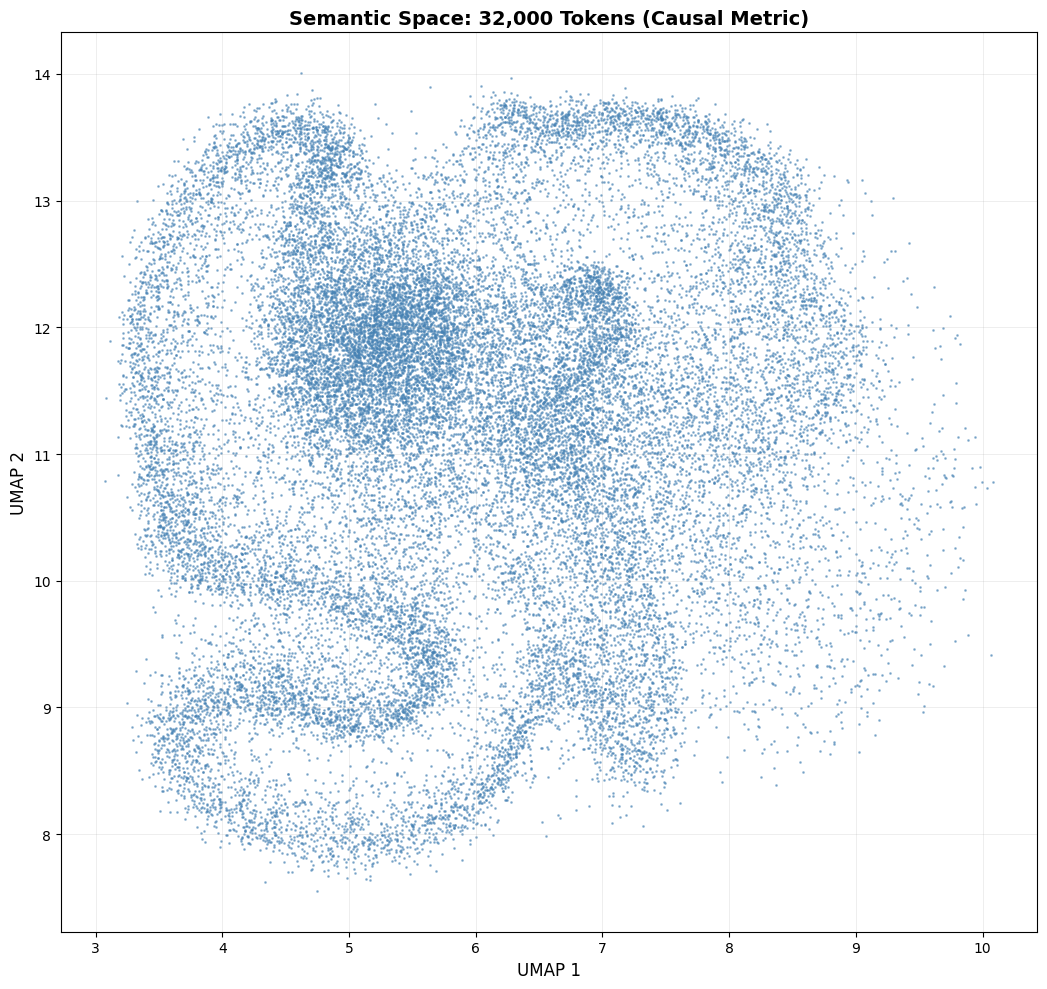


💡 Compare with 64k - same structure or different?


In [6]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,  # Point size
    alpha=0.5,
    c='steelblue',
    rasterized=True  # Better performance for many points
)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title(f'Semantic Space: {N:,} Tokens (Causal Metric)', fontsize=14, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n💡 Compare with 64k - same structure or different?")

## Statistics

In [7]:
print("\nEmbedding statistics:")
print(f"  X range: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}]")
print(f"  Y range: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")
print(f"  X mean: {embedding[:, 0].mean():.2f}")
print(f"  Y mean: {embedding[:, 1].mean():.2f}")
print(f"  X std: {embedding[:, 0].std():.2f}")
print(f"  Y std: {embedding[:, 1].std():.2f}")

# Compute radial distribution (distance from center)
center = embedding.mean(axis=0)
radii = np.sqrt(((embedding - center)**2).sum(axis=1))

print(f"\nRadial distribution (from center):")
print(f"  Mean radius: {radii.mean():.2f}")
print(f"  Median radius: {np.median(radii):.2f}")
print(f"  Std radius: {radii.std():.2f}")
print(f"  CV: {radii.std() / radii.mean() * 100:.1f}%")


Embedding statistics:
  X range: [3.08, 10.08]
  Y range: [7.55, 14.01]
  X mean: 5.92
  Y mean: 11.17
  X std: 1.43
  Y std: 1.46

Radial distribution (from center):
  Mean radius: 1.86
  Median radius: 1.83
  Std radius: 0.85
  CV: 45.7%


## Save Embedding

In [8]:
np.save(OUTPUT_EMBEDDING, embedding)
print(f"✓ Saved embedding to {OUTPUT_EMBEDDING}")
print(f"  Shape: {embedding.shape}")
print(f"  Size: {embedding.nbytes / 1e6:.2f} MB")

✓ Saved embedding to ../data/vectors/umap_embedding_32k.npy
  Shape: (32000, 2)
  Size: 0.26 MB


## Summary

This notebook computes and saves the 32k UMAP embedding.

**Output:** `data/vectors/umap_embedding_32k.npy`

**Next steps:**
- Use notebook 07.3 to color by causal norm
- Compare 32k structure with 16k/64k to see scale-dependent features